This is the notebook to show the implementation of score-based generative model (1st part of the tutorial). In this case, we will sample the training data from the swiss roll distribution.
From the training data, we will try to learn how to draw new samples from the swiss roll distribution with Score-based Generative Model (SGM)

In [17]:
import torch
from sklearn.datasets import make_swiss_roll
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

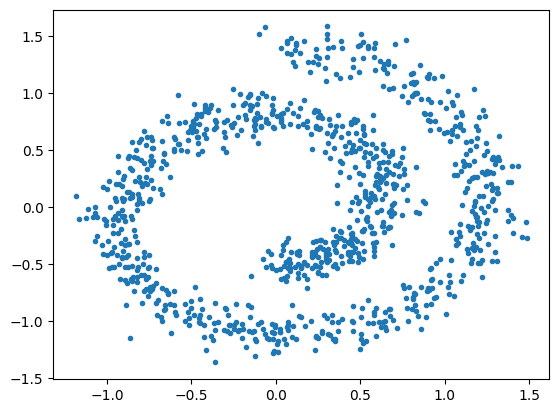

In [18]:
# show the samples
import matplotlib.pyplot as plt
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

Now let's define the neural network that will learn the score function.
This is just a simple multi-layer perceptron with LogSigmoid activation function.
I used logsigmoid because of personal preference, you can also use ReLU.

In [43]:
# score_network takes input of 2 dimension and returns the output of the same size
score_network = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)
score_network = score_network.cuda()
score_network

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): LogSigmoid()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): LogSigmoid()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): LogSigmoid()
  (6): Linear(in_features=64, out_features=2, bias=True)
)

Now let's implement the first and second terms of the loss function below,
$$\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\left[\frac{1}{2} \left\lVert\mathbf{s}(\mathbf{x};\theta)\right\rVert^2 + \mathrm{tr}\left(\nabla_\mathbf{x} \mathbf{s}(\mathbf{x}; \theta)\right) + g(\mathbf{x})\right].
\end{equation}$$
To get the Jacobian, we will use the function from ``functorch``.

In [ ]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_network(x)  # score: (batch_size, 2)
    
    # first term: half of the squared norm
    term1 = torch.linalg.norm(score, dim=-1) ** 2 * 0.5
    
    # second term: trace of the Jacobian
    jac = torch.vmap(torch.func.jacrev(score_network))(x)  # (batch_size, 2, 2)
    term2 = torch.einsum("bii->b", jac)  # compute the trace
    return (term1 + term2).mean()


Everything is ready, now we can start the training.

In [ ]:
# start the training loop
import time
from tqdm import tqdm
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
xtns = xtns.to(device)
dset = torch.utils.data.TensorDataset(xtns)
dloader = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True)
t0 = time.time()
# 1000 epochs seems enough to get an okay result
for i_epoch in tqdm(range(5000)):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()
        
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    # print the training stats
    if i_epoch % 100 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_2291912/1365434478.py:11: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  jac = vmap(jacrev(score_network))(x)  # (batch_size, 2, 2)
/tmp/ipykernel_2291912/1365434478.py:11: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  jac = vmap(jacrev(score_network))(x)  # (batch_size, 2, 2)
  0%|          | 1/1000 [00:00<10:2

0 (0.632239580154419s): -0.08916485921293497


 10%|█         | 101/1000 [01:05<09:53,  1.51it/s]

100 (65.84666705131531s): -2.2812286205291747


 20%|██        | 201/1000 [02:07<07:47,  1.71it/s]

200 (127.84067583084106s): -8.603028412699699


 30%|███       | 301/1000 [03:07<06:24,  1.82it/s]

300 (187.32208108901978s): -13.79245420074463


 40%|████      | 401/1000 [04:08<05:59,  1.67it/s]

400 (248.43173456192017s): -19.289352310180664


 50%|█████     | 501/1000 [05:08<05:12,  1.60it/s]

500 (308.87236070632935s): -28.43938171386719


 60%|██████    | 601/1000 [06:13<04:22,  1.52it/s]

600 (373.1397325992584s): -34.095817367553714


 70%|███████   | 701/1000 [07:14<03:15,  1.53it/s]

700 (434.57291412353516s): -37.42111624145508


 80%|████████  | 801/1000 [08:10<01:51,  1.78it/s]

800 (490.32570576667786s): -41.2194077911377


 90%|█████████ | 901/1000 [09:08<00:55,  1.77it/s]

900 (548.7154080867767s): -43.40652117919922


100%|██████████| 1000/1000 [10:06<00:00,  1.65it/s]


Once the neural network is trained, we can generate the samples using Langevin MCMC.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \varepsilon \nabla_\mathbf{x}\mathrm{log}\ p(\mathbf{x}) + \sqrt{2\varepsilon} \mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

In [45]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:
    # generate samples using Langevin MCMC
    # x0: (sample_size, nch)
    x0 = (torch.rand((nsamples, 2)) * 2 - 1).to(device)
    for i in range(nsteps):
        z = torch.randn_like(x0).to(device)
        x0 = x0 + eps * score_net(x0) + (2 * eps) ** 0.5 * z
    return x0

In [46]:
samples = generate_samples(score_network, 1000).detach()

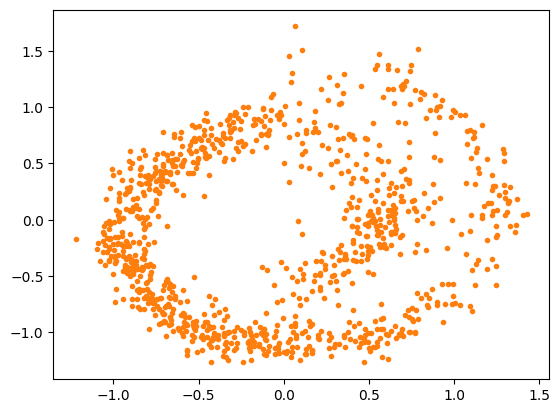

In [47]:
plt.plot(samples[:, 0].cpu(), samples[:, 1].cpu(), 'C1.')

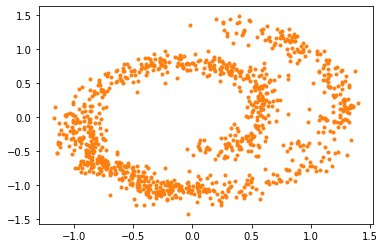

In [8]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')